In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from optbinning import OptimalBinning
from sklearn.tree import DecisionTreeClassifier
from natsort import natsorted

In [2]:
df = pd.read_csv(r"C:\Users\ruben\OneDrive\Desktop\Loan approvval\default_dataset.csv")

for col in df.columns:
    if df[col].isna().sum() > 0:
        print(f"Column {col} has {df[col].isna().sum()} missing values")
        if df[col].dtype in ['int64', 'float64']:
            df[col] = df[col].fillna(df[col].median())
        else:
            df[col] = df[col].fillna(df[col].mode()[0])

df.head()

Column person_emp_length has 895 missing values
Column loan_int_rate has 3116 missing values


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


### Explore binning options

In [ ]:
tree = DecisionTreeClassifier(max_leaf_nodes=4)
tree.fit(df[['loan_int_rate']], df['loan_status'])

df['binned'] = tree.apply(df[['loan_int_rate']])

df.groupby('binned')['loan_int_rate'].agg(['min', 'max', 'mean', 'count'])

,min,max,mean,count
binned,,,,
3,5.42,9.63,7.439281,10370
4,9.64,14.35,11.770741,17455
5,14.38,15.27,14.843903,1755
6,15.28,23.22,16.677694,3001


In [41]:
optbinner = OptimalBinning(name="loan_int_rate", dtype="numerical")

optbinner.fit(df['loan_int_rate'], df['loan_status'])

df['binned'] = optbinner.transform(df['loan_int_rate'], metric="bins")

bin_mapping = {bin_: i for i, bin_ in enumerate(natsorted(df['binned'].unique()))}
df['bin'] = df['binned'].map(bin_mapping)

df.groupby(['binned', 'bin'])['loan_int_rate'].agg(['min', 'max', 'mean', 'count']).sort_values(by='mean')

,,min,max,mean,count
binned,bin,,,,
"(-inf, 6.46)",0,5.42,6.39,5.828858,2084
"[6.46, 7.46)",1,6.54,7.43,6.942228,2531
"[7.46, 7.89)",2,7.49,7.88,7.634286,2569
"[7.89, 9.64)",3,7.90,9.63,8.730301,3186
"[9.64, 10.76)",4,9.64,10.75,10.300236,3645
"[10.76, 12.07)",5,10.78,12.04,11.248694,7426
"[12.07, 12.72)",6,12.09,12.72,12.461382,1831
"[12.72, 13.61)",7,12.73,13.61,13.216610,2891
"[13.61, 14.37)",8,13.62,14.35,14.052413,1662


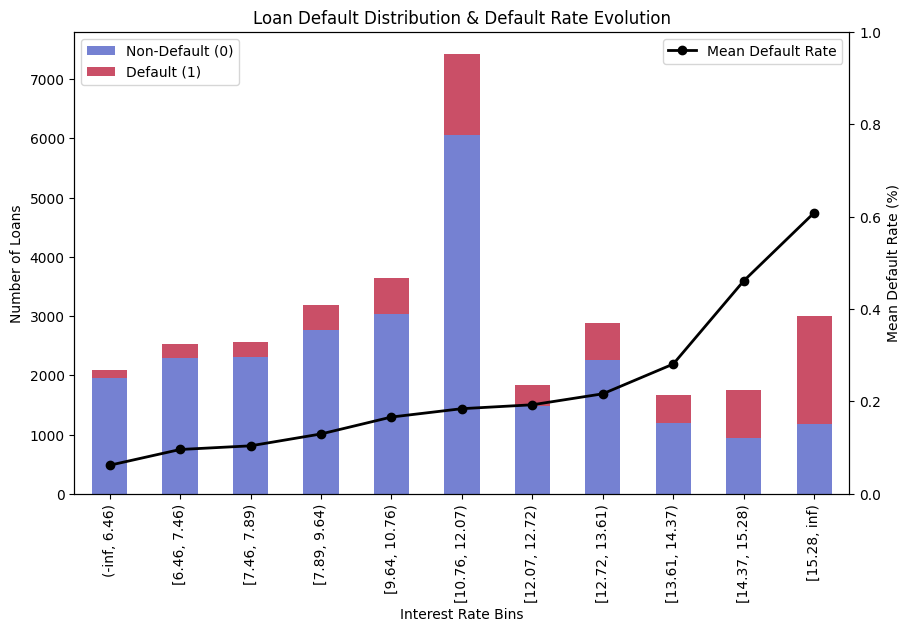

In [43]:
# Group by bins to count defaults vs. non-defaults
bin_counts = df.groupby(['binned', 'loan_status']).size().unstack(fill_value=0)

# Calculate mean default rate per bin
bin_default_rate = df.groupby('binned')['loan_status'].mean()

# Sort by bin order
bin_counts = bin_counts.loc[natsorted(bin_counts.index)]
bin_default_rate = bin_default_rate.loc[natsorted(bin_default_rate.index)]

# 🔹 PLOTTING 🔹
fig, ax1 = plt.subplots(figsize=(10, 6))

# Stacked bar plot for default & non-default counts
bin_counts.plot(kind='bar', stacked=True, ax=ax1, colormap="coolwarm", alpha=0.7)
ax1.set_xlabel("Interest Rate Bins")
ax1.set_ylabel("Number of Loans")
ax1.set_title("Loan Default Distribution & Default Rate Evolution")

# Create a second y-axis for default rate
ax2 = ax1.twinx()
ax2.plot(bin_default_rate.index, bin_default_rate.values, marker='o', color='black', linestyle='-', linewidth=2, label="Mean Default Rate")

ax2.set_ylabel("Mean Default Rate (%)")
ax2.set_ylim(0, 1)  # Default rate is between 0 and 1

# Show legend
ax1.legend(["Non-Default (0)", "Default (1)"], loc="upper left")
ax2.legend(loc="upper right")

plt.xticks(rotation=45)
plt.show()